In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

## Correlación: fluorescencia - motilidad

encodes (1017, 20)
tracks (101381, 5)
ids 1017
frames 119


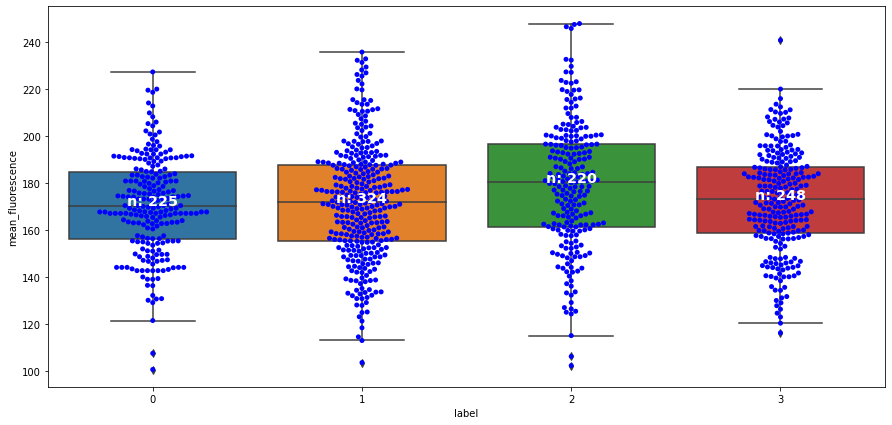

In [19]:
encodes = np.load('data/simulation_30hz/encodes.npy')
tracks = np.genfromtxt('data/simulation_30hz/trajectories.csv', delimiter=',', skip_header=True)
ids = np.unique(tracks[:, 0])
frames = np.unique(tracks[:, 4])
# id,x,y,fluorescence,frame
print('encodes', encodes.shape)
print('tracks', tracks.shape)
print('ids', len(ids))
print('frames', len(frames))

km = KMeans(n_clusters=4)
km.fit(encodes)

tracks_info = pd.DataFrame(columns=['id', 'label', 'mean_fluorescence'])
tracks_info['id'] = ids
tracks_info['label'] = km.labels_
# print(tracks_info)
mean_fluorescence = []
for k, track_id in enumerate(ids):
    track = tracks[tracks[:, 0] == track_id]
    mean_fluorescence.append(np.nanmean(track[track[:, 3] != 0][:, 3]))
tracks_info['mean_fluorescence'] = mean_fluorescence

fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="label", y="mean_fluorescence", data=tracks_info)
medians = tracks_info.groupby(['label'])['mean_fluorescence'].median().values
nobs = ["n: " + str(tracks_info['label'].value_counts()[i]) for i in sorted(tracks_info['label'].value_counts().index)]

# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-large', color='w', weight='semibold')

ax = sns.swarmplot(x='label', y='mean_fluorescence', data=tracks_info, color="blue")
plt.show()

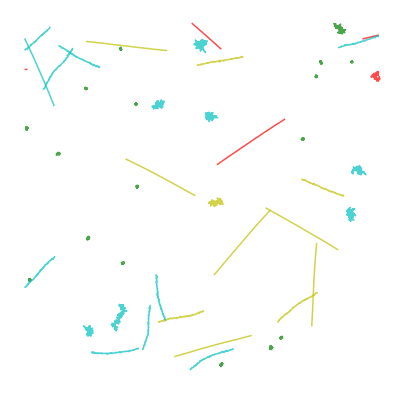

In [20]:
plt.figure(figsize=(7,7))
colors = ['r', 'c', 'g', 'y']
random_ids = np.random.choice(ids, size=50, replace=False)
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[label], alpha=0.7)
plt.axis('off')
plt.show()


## Casificación en función de la motilidad

encodes shape: (1017, 20)


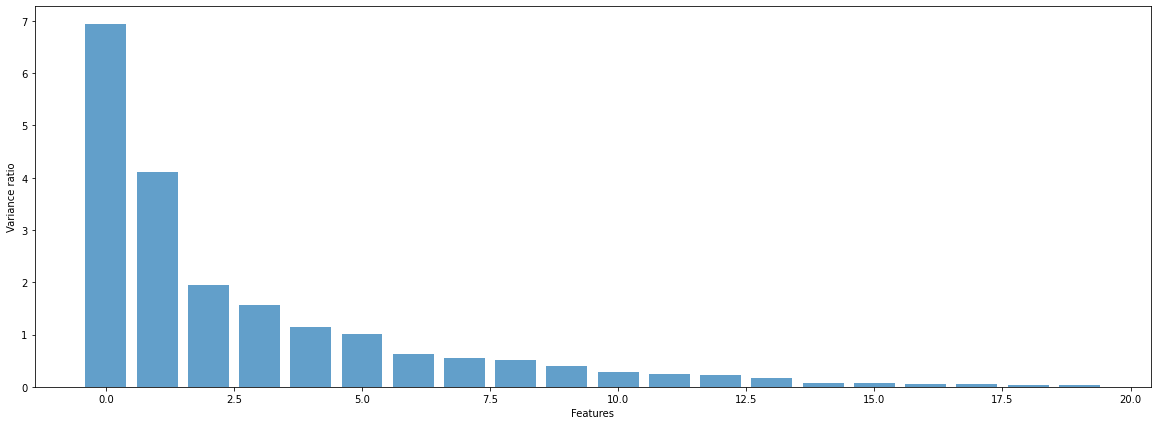

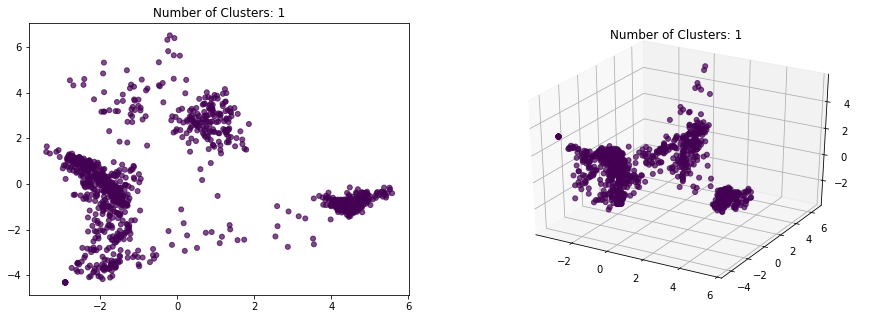

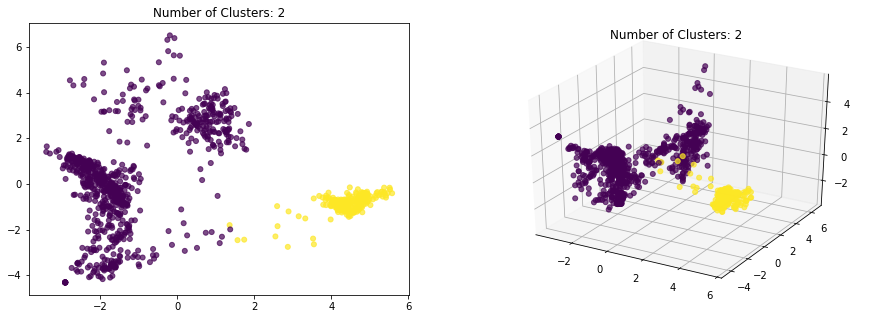

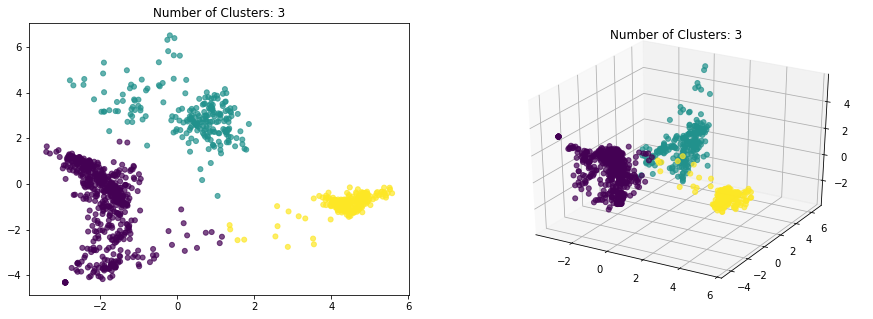

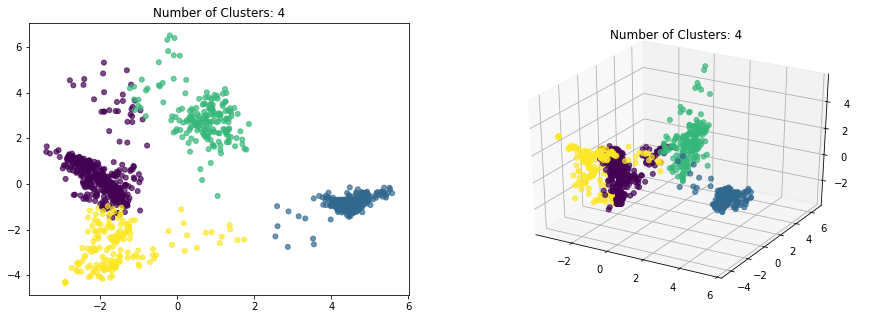

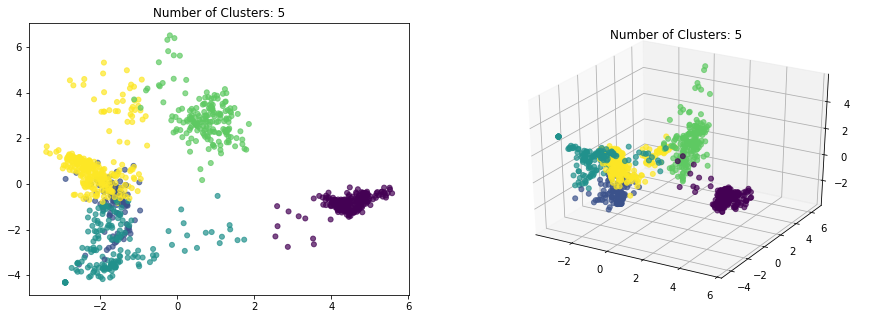

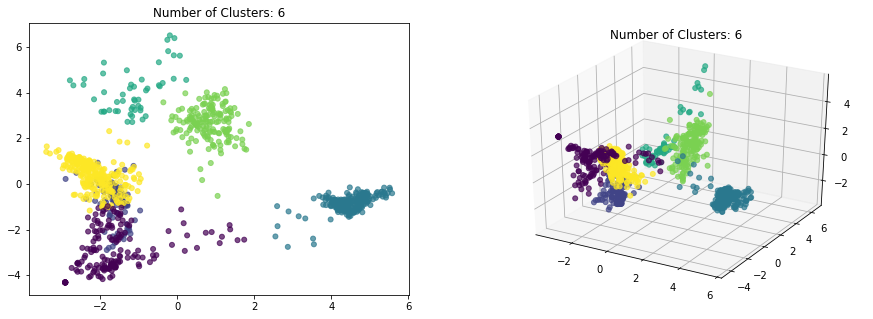

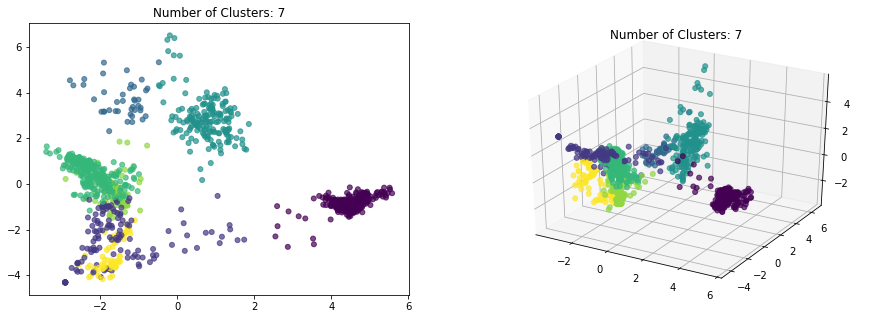

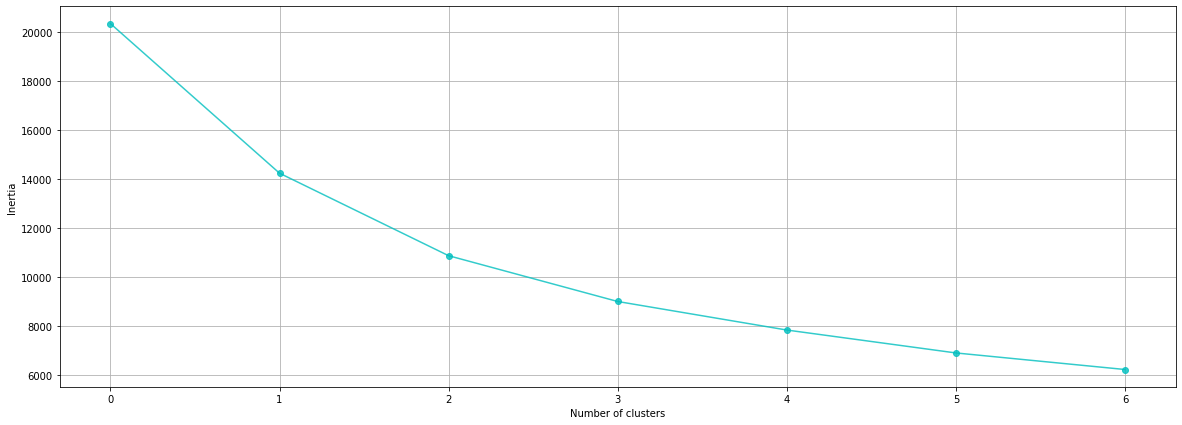

In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
print('encodes shape:', encodes.shape)
# normalize
scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.7)
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()

inertias = []
for i in range(1, 8):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    kmeans = KMeans(n_clusters=i)
    y_pred = kmeans.fit_predict(measures_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    inertias.append(kmeans.inertia_)
plt.show()

plt.figure(figsize=(20,7))
plt.plot(inertias, '-o', alpha=0.8, c='c')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.grid()
plt.show()

## Populations

In [57]:
gt_tracks = pd.read_csv('data/simulation_30hz/clustering_dataset(30Hz)_data.csv')
gt_tracks.head()

,id_particle,x,y,fluorescence,frame,id
0,NaN,395.949593,92.904094,182.047613,0.0,1.0
1,NaN,74.210951,319.180454,180.026202,0.0,11.0
2,NaN,92.508591,222.349084,184.900449,0.0,15.0
3,NaN,40.654389,405.738096,175.330013,0.0,16.0
4,NaN,383.938620,60.681746,154.247832,0.0,19.0


## Who classification

258 173.1517189728618
490 170.16626480437668
257 176.02206244065377
12 170.33487787308448


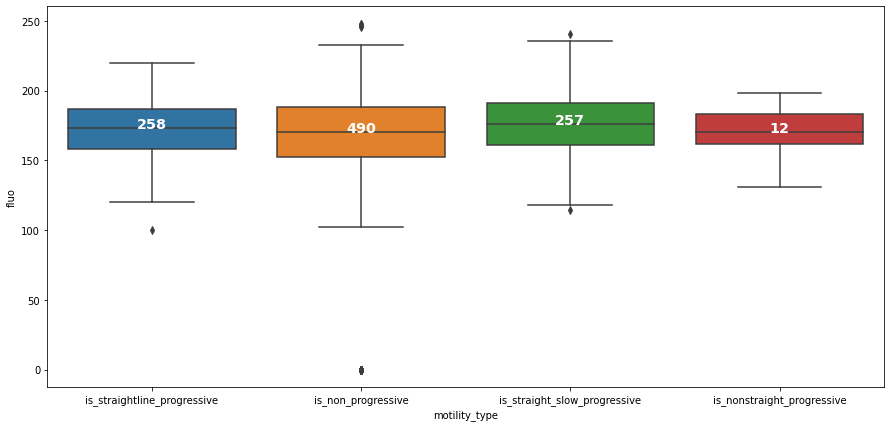

In [34]:
who_classification = pd.read_csv('data/simulation_30hz/who_classification.csv', index_col=False)
motility_types = who_classification['motility_type'].unique()

fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="motility_type", y="fluo", data=who_classification)
medians = who_classification.groupby(['motility_type'])['fluo'].median()
counts = who_classification['motility_type'].value_counts()
# Add it to the plot
pos = range(len(nobs))
for i, motility_type in enumerate(motility_types):
    median = medians[motility_type]
    num = counts[motility_type]
    print(num, median)
    ax.text(i, median, num, horizontalalignment='center', size='x-large', color='w', weight='semibold')

# ax = sns.swarmplot(x='motility_type', y='fluo', data=who_classification, color="blue")
plt.show()



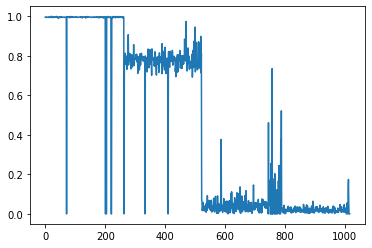

In [35]:
# print(who_classification['lin'])
plt.plot(who_classification['lin'])

In [36]:
from matplotlib.lines import Line2D

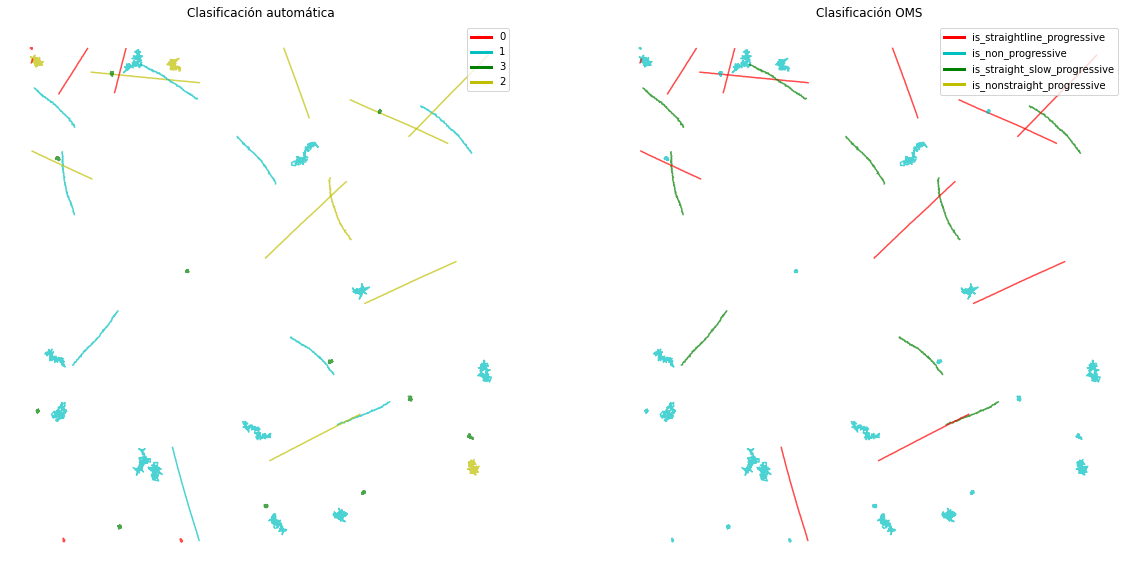

label is_non_progressive color:  c
label is_nonstraight_progressive color:  y
label is_straight_slow_progressive color:  g
label is_straightline_progressive color:  r


In [37]:
plt.figure(figsize=(20,10))
plt.subplot(121)
colors = ['r', 'c', 'g', 'y']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
random_ids = np.random.choice(ids, size=50, replace=False)
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[label], alpha=0.7)
plt.legend(lines, tracks_info['label'].unique(), loc='upper right')
plt.title('Clasificación automática')
plt.axis('off')

plt.subplot(122)
for random_id in random_ids:
    label = who_classification[who_classification['track_id'] == random_id]['motility_type'].values
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(motility_types == label)[0][0]], alpha=0.7)
    
plt.title('Clasificación OMS')
plt.legend(lines, who_classification['motility_type'].unique(), loc='upper right')
plt.axis('off')
plt.savefig('cluster_sim_tracks.png', bbox_inches='tight')
plt.show()
for label in np.unique(who_classification['motility_type']):
    print('label', label, 'color: ', colors[np.argwhere(motility_types == label)[0][0]])


## Who classification and trajectory encoding

In [54]:
encodes = np.load('data/simulation/encodes.npy')
# print(who_classification)
# print(tracks_info)
who_labels = list(who_classification['motility_type'].unique())
who_labels_legend = ['straight-line progressive', 'non progressive', 'straight-slow progressive', 'non-straight progressive']
print(who_labels)
print(who_labels_legend)

who_labels_int = [who_labels.index(label) for label in who_classification['motility_type']]
# print(who_labels_int)
print(len(who_classification['track_id'].unique()))
print('len(who_labels_int)', len(who_labels_int))

['is_straightline_progressive', 'is_non_progressive', 'is_straight_slow_progressive', 'is_nonstraight_progressive']
['straight-line progressive', 'non progressive', 'straight-slow progressive', 'non-straight progressive']
1017
len(who_labels_int) 1017


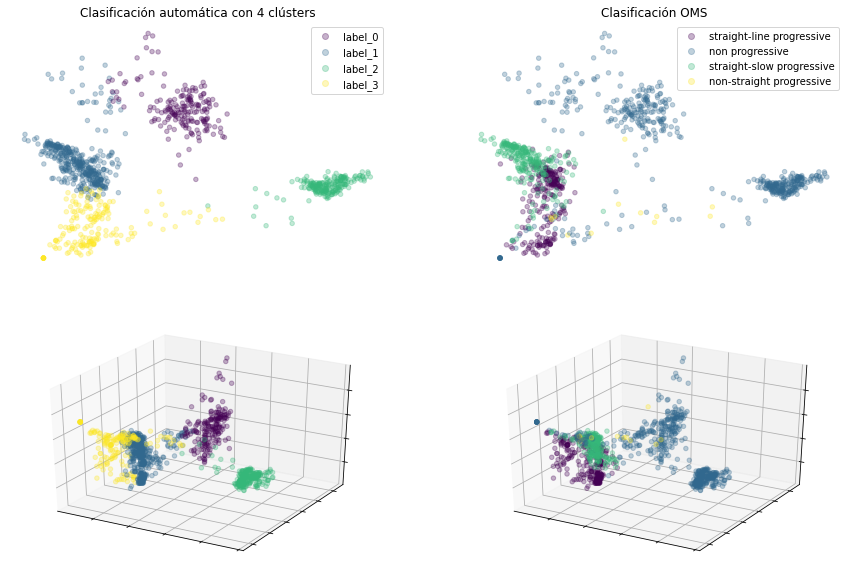

In [55]:
y_pred = KMeans(n_clusters=4).fit_predict(measures_scaled)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=20, alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2', 'label_3'], loc='upper right')
plt.title("Clasificación automática con 4 clústers")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=who_labels_int, s=20, alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación OMS")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=20, alpha=0.3)
# plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=who_labels_int, s=20, alpha=0.3)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

# plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend)
plt.savefig('clusters_oms.png', dpi=200, bbox_inches='tight')
plt.show()

## Urbano

Text(0.5, 0, 'ALH')

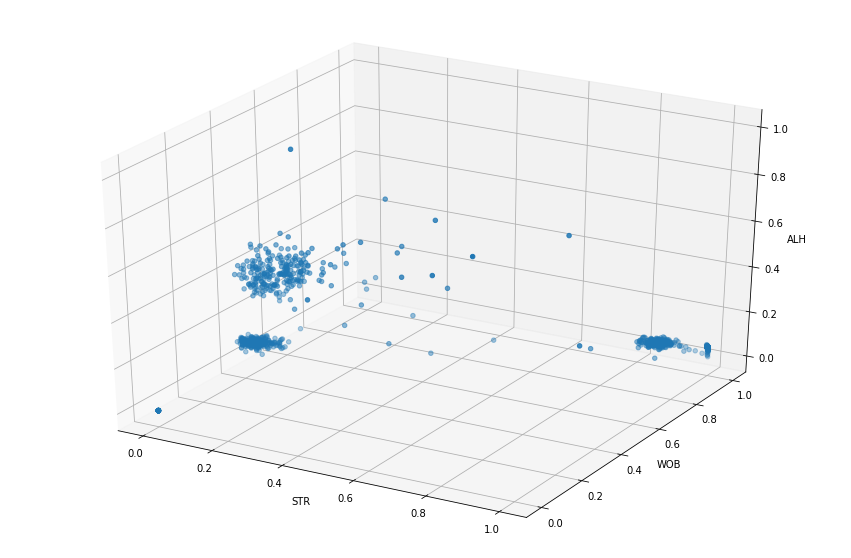

In [45]:
who_features = who_classification[['alh_mean', 'wob', 'str']]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(who_features['str']/who_features['str'].max(), who_features['wob']/who_features['wob'].max()
           , who_features['alh_mean']/who_features['alh_mean'].max())
ax.set_xlabel('STR')
ax.set_ylabel('WOB')
ax.set_zlabel('ALH')
# plt.show()

Text(0, 0.5, 'fluo')

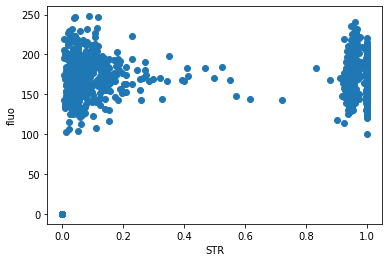

In [46]:
# print(who_classification)
plt.scatter(who_classification['str'], who_classification['fluo'])
plt.xlabel('STR')
plt.ylabel('fluo')
# plt.show()


## SVM - WHO

In [47]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [51]:
X = encodes
y = who_classification['motility_type']
N = encodes.shape[0]
labels = who_classification['motility_type'].unique()
print('labels:\n', labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

train_indices = np.random.choice(range(N), size=8*N//10)
val_indices = [i for i in range(N) if i not in train_indices]
X_train = X[train_indices, :]
y_train = y[train_indices]

X_val = X[val_indices, :]
y_val = y[val_indices]
print('Num train {}'.format(len(train_indices)))
print('Num val {}'.format(len(val_indices)))

labels:
 ['is_straightline_progressive' 'is_non_progressive'
 'is_straight_slow_progressive' 'is_nonstraight_progressive']


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [52]:
for label in labels:
    print('label {} in train: {:.2f}'.format(label, 100*np.sum(y_train==label)/len(y_train)))

NameError: name 'y_train' is not defined

Num train 1057
Num val 600


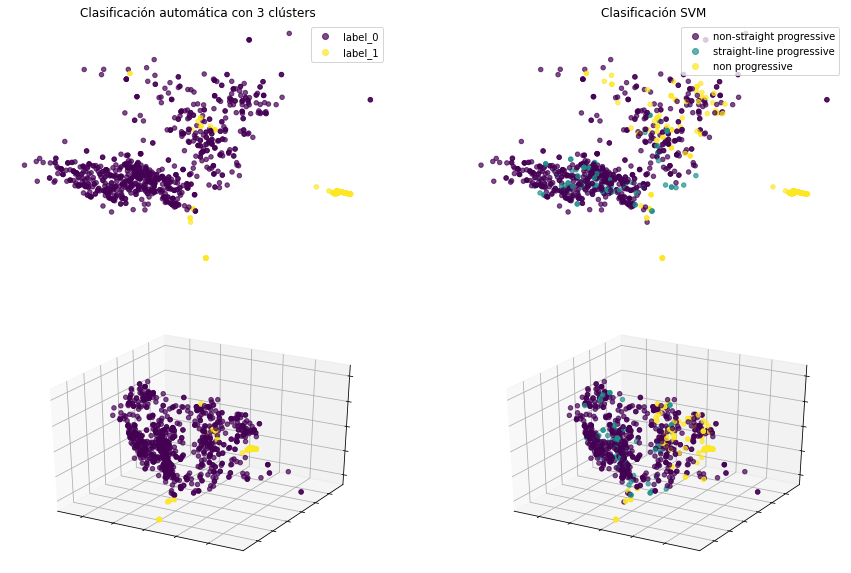

In [74]:


clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pca.fit_transform(X_train_scaled)
pred_labels = [np.argwhere(motility_types == label)[0][0] for _, label in enumerate(y_pred)]
train_labels = [np.argwhere(motility_types == label)[0][0] for _, label in enumerate(y_train)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=pred_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2'], loc='upper right')
plt.title("Clasificación automática con 3 clústers")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=train_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación SVM")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], c=pred_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], c=train_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

plt.savefig('svm_sim_oms_train.png', dpi=200, bbox_inches='tight')
plt.show()

Accuracy 0.85


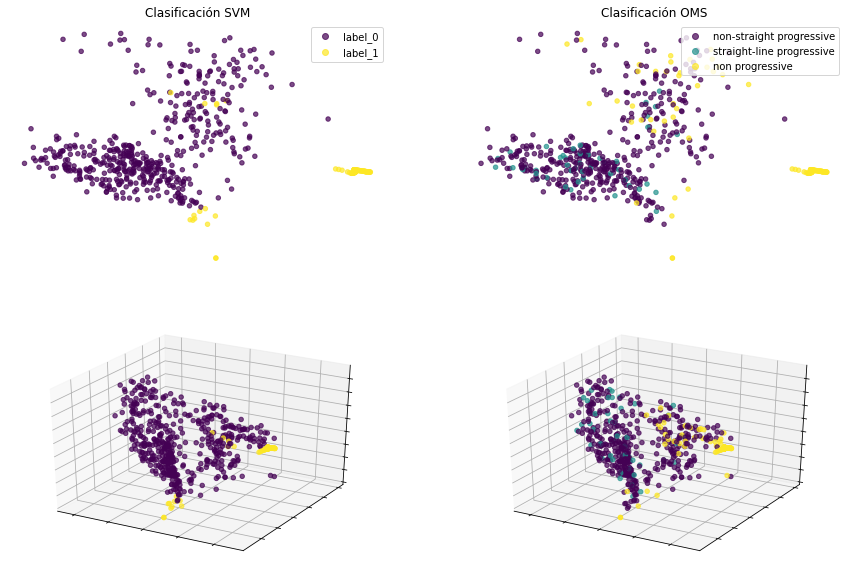

In [75]:
y_pred = clf.predict(X_val)
print('Accuracy {:.2f}'.format(np.sum(y_pred==y_val)/len(y_val)))

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pca.fit_transform(X_val_scaled)
pred_labels = [np.argwhere(motility_types == label)[0][0] for _, label in enumerate(y_pred)]
val_labels = [np.argwhere(motility_types == label)[0][0] for _, label in enumerate(y_val)]


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(221)
scatter = plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=pred_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['label_0', 'label_1', 'label_2'], loc='upper right')
plt.title("Clasificación SVM")
plt.axis('off')

plt.subplot(222)
scatter = plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=val_labels, s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels_legend, loc='upper right')
plt.title("Clasificación OMS")
plt.axis('off')

ax = fig.add_subplot(223, projection='3d')
scatter = ax.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], X_val_scaled[:, 2], c=pred_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

ax = fig.add_subplot(224, projection='3d')
scatter = ax.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], X_val_scaled[:, 2], c=val_labels, s=20, alpha=0.7)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_zticklabels(), visible=False)

plt.savefig('svm_sim_oms_val.png', dpi=200, bbox_inches='tight')
plt.show()

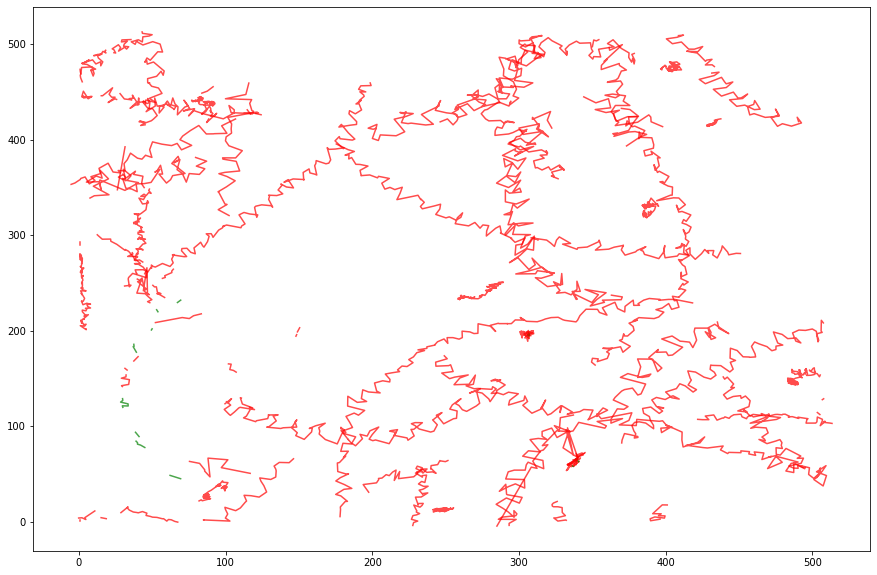

In [42]:
video = '1_026'
encodes = np.load('data/individual/' + video + '/encodes.npy')
tracks = np.genfromtxt('data/individual/' + video + '/trajectories.csv', delimiter=',', skip_header=True)
ids = np.unique(tracks[:, 0])

labels = clf.predict(encodes)

plt.figure(figsize=(15,10))
colors = ['r', 'c', 'g', 'y']
for i, track_id in enumerate(ids):
    label = labels[i]
#     print(i, track_id, label)
    track = tracks[tracks[:, 0] == track_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[np.argwhere(motility_types == label)[0][0]], alpha=0.7)
plt.show()